In [1]:
import torch
import torchvision
from Net import Net
import torch.optim as optim
import train
from Transformer import Transformer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

C:\Users\Stan\Anaconda3\envs\py36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
root = 'data\\'
network = Net()
network.load_state_dict(torch.load('results/model.pth'))

In [3]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), shuffle=True)

In [4]:
# here we transform our test set (10000 hand written imgs) into vector with shape (50,)
transform = Transformer(network)
vectors = []
targets = []
for data, target in test_loader:
    av = transform.get_vector(data).tolist()
    vectors.append(av)
    targets.append(target)

C:\Users\Stan\PycharmProjects\untitled\Net.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [5]:
from milvus import Milvus, IndexType, MetricType, Status

# connect
milvus = Milvus('127.0.0.1', '19530')
collection_name = 'cnn'
status, ok = milvus.has_collection(collection_name)
if ok:
    milvus.drop_collection(collection_name)

param = {
    'collection_name': collection_name,
    'dimension': 50
}
# create a milvus collection
milvus.create_collection(param)


Status(code=0, message='Create collection successfully!')

In [6]:
# insert the 10000 vectors
status, ids = milvus.insert(collection_name=collection_name, records=vectors)
print(status)

Status(code=0, message='Add vectors successfully!')


In [7]:
# initiate a map to keep track of {milvus_id: label}
label_map = {}
for idx, label in zip(ids, targets):
    label_map[idx]=int(label)

In [8]:
milvus.create_index('cnn', IndexType.IVF_FLAT, {'nlist': 600})

Status(code=0, message='Build index successfully!')

In [9]:
# perform the search, return topk results
y_hat = []
y = []
for i in range(len(vectors)):
    status, result = milvus.search(collection_name='cnn',query_records=[vectors[i]],
                  top_k=10,params={'nprobe':16})

    for query in result:
        for k in query:
            y_hat.append(label_map[k.id])
            y.append(targets[i])

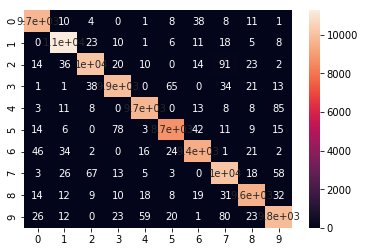

In [10]:
cf_matrix = confusion_matrix(y, y_hat)
sns.heatmap(cf_matrix, annot=True)


In [11]:
# accuracy
print(accuracy_score(y, y_hat))

0.98404
